### Load data

In [10]:
import pickle
with open('splitData.pickle', 'rb') as f:
    texts_train = pickle.load(f)
    texts_val = pickle.load(f)
    texts_test = pickle.load(f)
    labels_train = pickle.load(f)
    labels_val = pickle.load(f)
    labels_test = pickle.load(f)

all_texts  = texts_train  + texts_val  + texts_test
all_labels = labels_train + labels_val + labels_test
# check the ratio of each dataset
total = len(texts_train) + len(texts_val) + len(texts_test)
len(texts_train)/total, len(texts_val)/total, len(texts_test)/total

(0.5997757847533632, 0.20011210762331838, 0.20011210762331838)

# Q2-Clustering

### Step 0: Vectorise text

## NOTE: lyrics are not necessarily limited to English

In [3]:
import spacy

nlp = spacy.load('en_core_web_sm') # can tokenize Spanish at least

added_stop_words = set(["ayy","ay","ah","oh","ohh","ooh","la","da","dum","ll","d","m","ve","yah","yeah"])
my_stop_words = nlp.Defaults.stop_words.union(added_stop_words)

# nlp = spacy.load("xx_ent_wiki_sm") <-not work well for lemmanize

def text_pipeline_spacy(text):
    tokens = []
    doc = nlp(text)
    for t in doc:
        if not t.is_stop and not t.is_punct and not t.is_space and not t in my_stop_words:
            tokens.append(t.lemma_.lower())
    return tokens

# Check pipiline:
text_pipeline_spacy("Of all the things I miss, I miss my mind the most.")

['thing', 'miss', 'miss', 'mind']

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(tokenizer=text_pipeline_spacy, stop_words=my_stop_words)

texts_vector = vectorizer.fit_transform(all_texts)
texts_vector.shape

(1784, 19605)

## Conducting Kmeans

In [5]:
import numpy as np
np.random.seed(42)
def kmeans(k, matrix, max_iter=300):
    num_data, dim_feature = matrix.shape

    # Step1: pick k random centroids
    #### centroids = np.random.random([k,22406])  # Random Partition --- does not work well
    #Use Forgy partition to make sure at least one point is allocated to one point
    centroids = matrix[np.random.randint(0,num_data,k)]


    # new centroids to be calculated
    new_centroids = np.zeros((k,dim_feature))

    # labels(=index of centroids) assigned to data
    labels = np.zeros(num_data)

    # iterate until convergence or max_iteration
    for itr in range(max_iter):
        
        # iterate through all data
        for i in range(num_data):
            # matrix is a sparse vector, so make it dense array
            ith_vec = np.squeeze(np.asarray(matrix[i].todense()))

            #Step2: Assign each vector to its closest centroid
            dists = np.sum(np.square(centroids - ith_vec), axis=1)
            labels[i] = np.argmin(dists)

        #Step3:Recalculate the centroids
        for j in range(k):
            new_centroids[j] = matrix[labels==j].mean(axis=0)

        # If step 2 and 3 converges, exit for-loop         
        if np.all(new_centroids == centroids):
            print("converged")
            break;
        centroids = new_centroids

    return labels, new_centroids


clustered_labels, centroids = kmeans(5,texts_vector)
from collections import Counter
clustered_labels = [int(l) for l in clustered_labels]
Counter(clustered_labels)

converged


Counter({3: 689, 0: 885, 1: 130, 2: 20, 4: 60})

### For answering questions

In [6]:
# question a) show documents assigned to eatch cluster
shown = {} # labels checked
doc_samples = [[] for _ in range(5)]# documents sampled
for idx,l in enumerate(clustered_labels):
    if(shown.get(l,0) < 3):
        shown[l] = shown.get(l,0)+1
        doc_samples[l].append(all_texts[idx])
    
for label,docs in enumerate(doc_samples):
    print(f'\n=======label{label}=======')
    for i in range(3):
        print(f'{i}th docs')
        print(docs[i][:120])
        print('------------------')





=======label0=======
0th docs
Moonlight
Lyrics
The sun is setting and you're right here by my side
And the movie is playing, but we won't be watching 
------------------
1th docs
Shady XV
Shady XV Lyrics
I'm liable to start a violent spark with a silent thought
I disgust you like dialogue from The 
------------------
2th docs
Write Your Name
Write Your Name Lyrics
Take my arm, take my head
Make your mark like a man
Write your name
Gonna write y
------------------

=======label1=======
0th docs
On the Floor (Mixin Marc & Tony Svejda L.A. to Ibiza Mix)
On the Floor (Mixin Marc & Tony Svejda L.A. to Ibiza Mix) Lyri
------------------
1th docs
​in my head
Grande - in my head (Srpski Prevod)PortuguêsAriana Grande - in my head (polskie tłumaczenie)ItalianoDeutschف
------------------
2th docs
Don’t Walk Away
Don’t Walk Away Lyrics
Ooh, don't walk away
Walk away

Don't walk away
See, I just can't find the right 
------------------

=======label2=======
0th docs
INUYASHA
Lyrics
Damn, baby, wha

In [7]:
# question a)
for i in range(5):
    print(f"------top 5 tokens in centroid {i}-----")
    indices = np.argsort(centroids[i])[-5:] # indices of most prominent tokens
    for key,val in vectorizer.vocabulary_.items():
        if val in indices:
            print(f'{key}',end=",")
    print("\n")

# tokenizerを工夫したほうがよいかも

------top 5 tokens in centroid 0-----
know,feel,like,fuck,let,

------top 5 tokens in centroid 1-----
stay,bitch,away,work,walk,

------top 5 tokens in centroid 2-----
animal,jump,damn,glad,effect,

------top 5 tokens in centroid 3-----
want,know,love,like,baby,

------top 5 tokens in centroid 4-----
like,people,world,woman,million,



In [8]:
# question c) construct a confusion matrix
# correspond labels(songer names) with integers
label2id = {label: i for i, label in enumerate(set(labels_train))}
id2label = {id:label for label,id in label2id.items()}

print(Counter(clustered_labels))

cm = [[0 for _ in range(5)] for _ in range(10)]
for idx, label in enumerate(all_labels):
    true_id = label2id[label] 
    pred_id = clustered_labels[idx]
    cm[true_id][pred_id] += 1
cm = np.array(cm)
np.sum(cm,axis=0)

Counter({0: 885, 3: 689, 1: 130, 4: 60, 2: 20})


array([885, 130,  20, 689,  60])

In [9]:
a = list(label2id.keys())
labels_y = ['Eminem', 'Beyonce Knowles', 'Dua Lipa', 'Selena Gomez', 'Michael Jackson', 'Ariana Grande', 'Taylor Swift', 'Lady Gaga', 'XXXTentacion', 'Jennifer Lopez']
a == labels_y

False

<AxesSubplot:xlabel='k-means labels', ylabel='Target labels'>

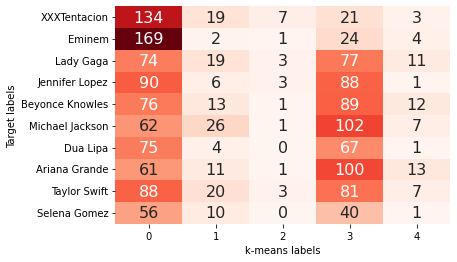

In [10]:
# show confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sn

def plotConfusionMatrix(cm, labels_val, labels_predicted):
  cm = cm
  colour_map = sn.color_palette("Reds", as_cmap=True)
  labels_x = labels_val
  labels_y = labels_predicted #list(label2id.keys())#['Eminem', 'Beyonce Knowles', 'Dua Lipa', 'Selena Gomez', 'Michael Jackson', 'Ariana Grande', 'Taylor Swift', 'Lady Gaga', 'XXXTentacion', 'Jennifer Lopez']
  plot = sn.heatmap(cm, 
                    annot=True, # Put the numbers in
                    annot_kws={"size": 16}, # Make the numbers bigger
                    fmt='g', # Stop scientific notation
                    cmap = colour_map, # Choose the colour palette
                    cbar = False, # Don't include the colour bar
                    xticklabels=labels_x,#labels_x, # Put in the X and Y labels
                    yticklabels=labels_y)
  plot.set(xlabel='k-means labels', ylabel='Target labels')
  return plot

plotConfusionMatrix(cm, [str(i) for i in range(5)] ,list(label2id.keys()))

In [12]:
# unnecessary
from sklearn.cluster import KMeans
from collections import Counter
kmeans = KMeans(n_clusters=5, random_state=10).fit_predict(texts_vector)
Counter(kmeans)

Counter({2: 1010, 4: 378, 3: 257, 0: 118, 1: 21})

# Q3-Comparing Classifiers

In [4]:

# Show classifier performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def showPerformance(labels_true, labels_predicted):
    print(f'accuracy ={accuracy_score(labels_true, labels_predicted):.3f}')
    print(f'precision={precision_score(labels_true, labels_predicted, average="macro"):.3f}')
    print(f'recall   ={recall_score(labels_true, labels_predicted, average="macro"):.3f}') 
    print(f'f1       ={f1_score(labels_true, labels_predicted, average="macro"):.3f}')
    return ;


### Dummy Classifier with strategy="most_frequent"

In [20]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(texts_train,labels_train)
labels_predicted = dummy_clf.predict(texts_val)

print(dummy_clf.score(texts_val, labels_val))
print("on validation")
showPerformance(labels_val, labels_predicted)
print("\non training")
showPerformance(labels_train, dummy_clf.predict(texts_train))

0.08403361344537816
on validation
accuracy =0.084
precision=0.008
recall   =0.100
f1       =0.016

on training
accuracy =0.127
precision=0.013
recall   =0.100
f1       =0.023


/home/denjo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/denjo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Dummy Classifier with strategy="stratified"

In [22]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(texts_train,labels_train)
labels_predicted = dummy_clf.predict(texts_val)

# print(dummy_clf.score(texts_val, labels_val))
showPerformance(labels_val, labels_predicted)

print("\non training")
showPerformance(labels_train, dummy_clf.predict(texts_train))

accuracy =0.106
precision=0.101
recall   =0.101
f1       =0.100

on training
accuracy =0.095
precision=0.090
recall   =0.090
f1       =0.090


### LogisticRegression with one-hot vectorization

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
vectorizer = CountVectorizer(tokenizer=text_pipeline_spacy,stop_words=my_stop_words)

vect_texts_train = vectorizer.fit_transform(texts_train)
vect_texts_train[vect_texts_train != 0] = 1 # convert non-zero counting into 1

vect_texts_val = vectorizer.transform(texts_val)
vect_texts_val[vect_texts_val != 0] = 1

# Logistic Regression
clf = LogisticRegression(random_state=42,max_iter=1000).fit(vect_texts_train, labels_train)
labels_predicted = clf.predict(vect_texts_val)


showPerformance(labels_val, labels_predicted)

print("\non training")
showPerformance(labels_train, clf.predict(vect_texts_train))

accuracy =0.563
precision=0.565
recall   =0.567
f1       =0.556

on training
accuracy =1.000
precision=1.000
recall   =1.000
f1       =1.000


### LogisticRegression with TF-IDF vectorization

In [26]:
vectorizer = TfidfVectorizer(tokenizer=text_pipeline_spacy,stop_words=my_stop_words)
vect_texts_train = vectorizer.fit_transform(texts_train)
vect_texts_val = vectorizer.transform(texts_val)

# Logistic Regression
clf = LogisticRegression(random_state=42).fit(vect_texts_train, labels_train)
labels_predicted = clf.predict(vect_texts_val)


showPerformance(labels_val, labels_predicted)

print("\non training")
showPerformance(labels_train, clf.predict(vect_texts_train))


accuracy =0.451
precision=0.424
recall   =0.444
f1       =0.413

on training
accuracy =0.895
precision=0.906
recall   =0.867
f1       =0.874


/home/denjo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### SVC Classifier with One-hot vectorization

In [27]:
# making one-hot vectors
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(tokenizer=text_pipeline_spacy,stop_words=my_stop_words)
vect_texts_train = vectorizer.fit_transform(texts_train)
vect_texts_train[vect_texts_train != 0] = 1 # convert non-zero counting into 1

vect_texts_val = vectorizer.transform(texts_val)
vect_texts_val[vect_texts_val != 0] = 1

from sklearn.svm import SVC
clf = SVC(random_state=42).fit(vect_texts_train, labels_train)
labels_predicted = clf.predict(vect_texts_val)


showPerformance(labels_val, labels_predicted)

print("\non training")
showPerformance(labels_train, clf.predict(vect_texts_train))

accuracy =0.518
precision=0.498
recall   =0.514
f1       =0.481

on training


/home/denjo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy =0.936
precision=0.943
recall   =0.912
f1       =0.919


#### bar chart for F1 scores in LR with One-hot

In [28]:
# calculate labels again
vectorizer = CountVectorizer(tokenizer=text_pipeline_spacy,stop_words=my_stop_words)

vect_texts_train = vectorizer.fit_transform(texts_train)
vect_texts_train[vect_texts_train != 0] = 1 # convert non-zero counting into 1
vect_texts_val = vectorizer.transform(texts_val)
vect_texts_val[vect_texts_val != 0] = 1
# Logistic Regression
clf = LogisticRegression(random_state=42,max_iter=1000).fit(vect_texts_train, labels_train)
labels_predicted = clf.predict(vect_texts_val)


showPerformance(labels_val, labels_predicted)

accuracy =0.563
precision=0.565
recall   =0.567
f1       =0.556


/tmp/ipykernel_30475/267435486.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


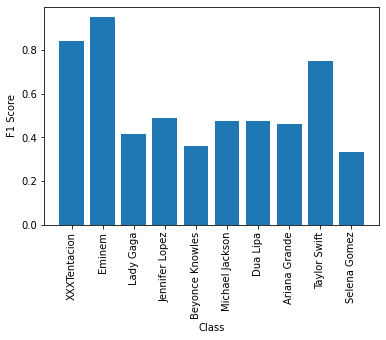

In [43]:
#a) drawing a bar chart for F1 scores
import matplotlib.pyplot as plt

# Calculate F1 score for each class
label_set = set(labels_val)
f1_scores = np.zeros(10)
for idx,l in enumerate(label_set):
    true_mask = np.array(labels_val) == l
    pred_mask = np.array(labels_predicted) == l
    f1_scores[idx] = f1_score(true_mask, pred_mask)

# Plot bar chart with F1 score for each class
fig = plt.figure()
ax = fig.add_subplot()
ax.bar(range(10), f1_scores)
ax.set_xlabel("Class")
ax.set_ylabel("F1 Score")
ax.set_xticks(range(10))

ax.set_xticklabels(list(label_set),rotation=90)
fig.savefig("./figures/F1score.png", bbox_inches="tight")
fig.show()


### b) my classifier

In [79]:
# my tokenizer
def my_text_pipeline_spacy(text):
    tokens = []
    doc = nlp(text)
    for t in doc:
        # maintain punctuation, stopwords, Capital words
        if not t.is_space:
            tokens.append(t.lemma_)
    return tokens
vectorizer = TfidfVectorizer(tokenizer=my_text_pipeline_spacy)#tokenizer=None, stop_words=None,lowercase=False)
print(vectorizer.fit_transform(["Oh-oh-oh \tah ah"]).todense())
vectorizer.vocabulary_.keys()


[[0.48507125 0.48507125 0.72760688]]


dict_keys(['oh', '-', 'ah'])

In [80]:
vectorizer = TfidfVectorizer(tokenizer=my_text_pipeline_spacy)
vect_texts_train = vectorizer.fit_transform(texts_train)
vect_texts_val = vectorizer.transform(texts_val)

print(vect_texts_train.shape)
# Logistic Regression
clf = LogisticRegression(random_state=42).fit(vect_texts_train, labels_train)
labels_predicted = clf.predict(vect_texts_val)


showPerformance(labels_val, labels_predicted)

print("\non training")
showPerformance(labels_train, clf.predict(vect_texts_train))


(1070, 15354)
accuracy =0.443
precision=0.413
recall   =0.437
f1       =0.403

on training
accuracy =0.839
precision=0.854
recall   =0.805
f1       =0.812


/home/denjo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [74]:
vect_texts_train[0].todense()
for i in vectorizer.vocabulary_.keys():
    if(i == '-'):
        print("find")

find


# Q4-Parameter Tuning

#### choose C value

In [102]:

import pandas as pd
results = pd.DataFrame({"parameter":[],
                        "accuracy":[],
                        "precision":[],
                        "recall":[],
                        "F1":[]})
a=10
results.loc[f'0{a}'] = [0.11111,0.2,0.1,0.3,0.4]
results.round(3)

,parameter,accuracy,precision,recall,F1
010,0.111,0.2,0.1,0.3,0.4


In [105]:
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid
param_C = {'C':np.logspace(-3,5,9,base=10.0)}

results = pd.DataFrame({"accuracy":[],
                        "precision":[],
                        "recall":[],
                        "F1":[]})

# max_f1 = 0
# best_param = {}
for params in tqdm(ParameterGrid(param_C)):
  # vectorize training set and validation set
  vectorizer = TfidfVectorizer(tokenizer=text_pipeline_spacy, stop_words=my_stop_words)
  vect_texts_train = vectorizer.fit_transform(texts_train)
  vect_texts_val = vectorizer.transform(texts_val)

  # logistic regression
  clf = LogisticRegression(random_state=42,C=params['C'],max_iter=1000).fit(vect_texts_train, labels_train)
  labels_predicted = clf.predict(vect_texts_val)

  results.loc[f"C={params['C']}"] = [accuracy_score(labels_val, labels_predicted),
                                     precision_score(labels_val,labels_predicted,average="macro"),
                                     recall_score(labels_val, labels_predicted, average="macro"),
                                     f1_score(labels_val, labels_predicted, average="macro")
                                    ]
#   cur_f1 = f1_score(labels_val, labels_predicted,average="macro")
#   if(cur_f1 > max_f1):
#     max_f1 = cur_f1
#     best_param = params

# print(f'{best_param=}')
# print(f'{max_f1:.3f}')
results.round(3)



  0%|          | 0/9 [00:00<?, ?it/s]/home/denjo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 11%|█         | 1/9 [02:11<17:35, 131.88s/it]/home/denjo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 22%|██▏       | 2/9 [04:09<14:23, 123.40s/it]/home/denjo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

,accuracy,precision,recall,F1
C=0.001,0.084,0.008,0.100,0.016
C=0.01,0.084,0.008,0.100,0.016
C=0.1,0.263,0.346,0.269,0.233
C=1.0,0.457,0.434,0.451,0.421
C=10.0,0.485,0.489,0.484,0.479
C=100.0,0.473,0.469,0.472,0.466
C=1000.0,0.468,0.460,0.467,0.461
C=10000.0,0.462,0.455,0.463,0.456
C=100000.0,0.462,0.455,0.462,0.455


#### choose vectorizer

In [107]:
param_vec = {'max_features':[None, 5, 50, 500, 5000, 50000], 'sublinear_tf':[True,False]}

results = pd.DataFrame({"accuracy":[],
                        "precision":[],
                        "recall":[],
                        "F1":[]})
# max_f1 = 0
# best_param = {}
for params in tqdm(ParameterGrid(param_vec)):
  # vectorize training set and validation set
  vectorizer = TfidfVectorizer(tokenizer=text_pipeline_spacy,stop_words=my_stop_words, max_features=params["max_features"], sublinear_tf=params["sublinear_tf"])
  vect_texts_train = vectorizer.fit_transform(texts_train)
  vect_texts_val = vectorizer.transform(texts_val)

  # logistic regression
  clf = LogisticRegression(random_state=42,C=10,max_iter=1000).fit(vect_texts_train, labels_train)
  labels_predicted = clf.predict(vect_texts_val)

  results.loc[f"MF={params['max_features']},SF={params['sublinear_tf']}"] = \
                                    [accuracy_score(labels_val, labels_predicted),
                                     precision_score(labels_val,labels_predicted,average="macro"),
                                     recall_score(labels_val, labels_predicted, average="macro"),
                                     f1_score(labels_val, labels_predicted, average="macro")
                                    ]
#   cur_f1 = f1_score(labels_val, labels_predicted,average="macro")
#   if(cur_f1 > max_f1):
#     max_f1 = cur_f1
#     best_param = params

# print(f'{best_param=}')
# print(f'{max_f1:.3f}')
results.round(3)


 17%|█▋        | 2/12 [03:57<19:46, 118.67s/it]/home/denjo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 25%|██▌       | 3/12 [05:42<16:55, 112.79s/it]/home/denjo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 12/12 [19:21<00:00, 96.80s/it]


,accuracy,precision,recall,F1
"MF=None,SF=True",0.571,0.584,0.565,0.554
"MF=None,SF=False",0.485,0.489,0.484,0.479
"MF=5,SF=True",0.196,0.124,0.203,0.147
"MF=5,SF=False",0.196,0.124,0.205,0.143
"MF=50,SF=True",0.412,0.415,0.423,0.407
"MF=50,SF=False",0.367,0.366,0.369,0.358
"MF=500,SF=True",0.499,0.504,0.501,0.495
"MF=500,SF=False",0.415,0.418,0.422,0.414
"MF=5000,SF=True",0.577,0.589,0.575,0.567
"MF=5000,SF=False",0.473,0.470,0.473,0.465


In [115]:
# Choose penalty and vectorizer
param_vec = {'penalty':['none','l2','l1','elasticnet']}

results = pd.DataFrame({"accuracy":[],
                        "precision":[],
                        "recall":[],
                        "F1":[]})
# vectorize training set and validation set
vectorizer = TfidfVectorizer(tokenizer=text_pipeline_spacy,stop_words=my_stop_words,max_features=5000, sublinear_tf=True)#, max_features=params["max_features"], sublinear_tf=params["sublinear_tf"])
vect_texts_train = vectorizer.fit_transform(texts_train)
vect_texts_val = vectorizer.transform(texts_val)
for params in tqdm(ParameterGrid(param_vec)):

  # logistic regression
  clf = LogisticRegression(random_state=42,C=10,max_iter=10000,penalty=params["penalty"],solver='saga',l1_ratio=0.5).fit(vect_texts_train, labels_train)
  labels_predicted = clf.predict(vect_texts_val)

  results.loc[f"param:{params['penalty']}"] =  \
                                    [accuracy_score(labels_val, labels_predicted),
                                     precision_score(labels_val,labels_predicted,average="macro"),
                                     recall_score(labels_val, labels_predicted, average="macro"),
                                     f1_score(labels_val, labels_predicted, average="macro")
                                    ]
results.round(3)

  0%|          | 0/4 [00:00<?, ?it/s]/home/denjo/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
/home/denjo/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
 25%|██▌       | 1/4 [00:05<00:16,  5.61s/it]/home/denjo/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
 50%|█████     | 2/4 [00:06<00:06,  3.04s/it]/home/denjo/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
100%|██████████| 4/4 [00:34<00:00,  8.53s/it]


,accuracy,precision,recall,F1
param:none,0.552,0.560,0.554,0.549
param:l2,0.577,0.589,0.575,0.567
param:l1,0.499,0.496,0.503,0.492
param:elasticnet,0.535,0.557,0.537,0.531


In [22]:
#たぶんいらない
param_vec = {'max_features':[None, 5, 50, 500, 5000, 50000], 'sublinear_tf':[True,False]}

max_f1 = 0
best_param = {}
for params in tqdm(ParameterGrid(param_vec)):
  # vectorize training set and validation set
  vectorizer = TfidfVectorizer(max_features=params["max_features"], sublinear_tf=params["sublinear_tf"])
  vect_texts_train = vectorizer.fit_transform(texts_train)
  vect_texts_val = vectorizer.transform(texts_val)

  # logistic regression
  clf = LogisticRegression(random_state=42,C=100,max_iter=1000).fit(vect_texts_train, labels_train)
  labels_predicted = clf.predict(vect_texts_val)

  cur_f1 = f1_score(labels_val, labels_predicted,average="macro")
  if(cur_f1 > max_f1):
    max_f1 = cur_f1
    best_param = params

print(f'{best_param=}')
print(f'{max_f1:.3f}')

  0%|          | 0/12 [00:09<?, ?it/s]


KeyboardInterrupt: 

# Q5-Context vectors using BERT

In [5]:
from transformers import AutoTokenizer

import torch
# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

ModuleNotFoundError: No module named 'torch'

In [3]:
tokenizer.tokenize("I walked through Kelvingrove.")

['i', 'walked', 'through', 'kelvin', '##grove', '.']

In [39]:
import numpy as np
def softmax(z):
    assert len(z.shape) == 2


    s = np.max(z, axis=1)
    s = s[:, np.newaxis] # necessary step to do broadcasting
    e_x = np.exp(z - s)
    div = np.sum(e_x, axis=1)
    div = div[:, np.newaxis] # dito
    return e_x / div


x1 = np.array([[12.1,91.1,89.3, 44.1]])
softmax(x1)


array([[4.21015997e-35, 8.58148935e-01, 1.41851065e-01, 3.32446694e-21]])

# Q6

In [68]:
import pickle
with open ("test_resultsE.pickle","rb") as f:
    t_labels_predicted = pickle.load(f)
    t_label_ids = pickle.load(f)

print(len(t_label_ids))
len(t_labels_predicted)

357


357

In [69]:
t_labels_predicted[:10]
t_label_ids[:10]

array([0, 2, 0, 1, 2, 8, 5, 9, 5, 6])

In [70]:

def showPerformance(labels_true, labels_predicted):
    print(f'accuracy ={accuracy_score(labels_true, labels_predicted):.3f}')
    print(f'precision={precision_score(labels_true, labels_predicted, average="macro"):.3f}')
    print(f'recall   ={recall_score(labels_true, labels_predicted, average="macro"):.3f}') 
    print(f'f1       ={f1_score(labels_true, labels_predicted, average="macro"):.3f}')
    return ;

In [71]:
showPerformance(t_label_ids, t_labels_predicted)

accuracy =0.597
precision=0.617
recall   =0.592
f1       =0.591


In [86]:
# correspond labels(songer names) with integers
label2id = {label: i for i, label in enumerate(set(labels_train))}
id2label = {id:label for label,id in label2id.items()}
labels_train_int = [label2id[l] for l in labels_train]
labels_val_int = [label2id[l] for l in labels_val]

In [73]:
showPerformance(t_label_ids, t_labels_predicted)

accuracy =0.597
precision=0.617
recall   =0.592
f1       =0.591


In [102]:
from sklearn.metrics import confusion_matrix
# confusion_matrix(t_label_ids, t_labels_predicted)

# show confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sn

def plotConfusionMatrix(cm, labels_val, labels_predicted):
  # cm = cm
  colour_map = sn.color_palette("Reds", as_cmap=True)
  labels_x = labels_val
  labels_y = labels_predicted #list(label2id.keys())#['Eminem', 'Beyonce Knowles', 'Dua Lipa', 'Selena Gomez', 'Michael Jackson', 'Ariana Grande', 'Taylor Swift', 'Lady Gaga', 'XXXTentacion', 'Jennifer Lopez']
  plot = sn.heatmap(cm, 
                    annot=True, # Put the numbers in
                    annot_kws={"size": 16}, # Make the numbers bigger
                    fmt='g', # Stop scientific notation
                    cmap = colour_map, # Choose the colour palette
                    cbar = False, # Don't include the colour bar
                    xticklabels=labels_x,#labels_x, # Put in the X and Y labels
                    yticklabels=labels_y)
  plot.set(xlabel='Predicted labels', ylabel='Target labels')
  return plot


<AxesSubplot:xlabel='Predicted labels', ylabel='Target labels'>

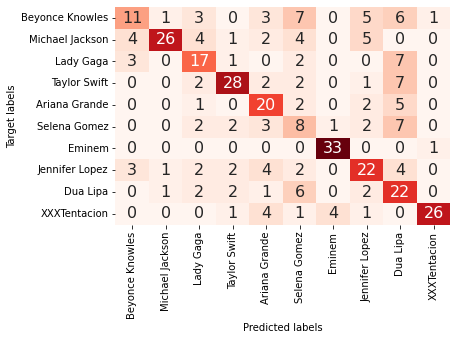

In [103]:
cm = confusion_matrix(t_label_ids, t_labels_predicted)
plotConfusionMatrix(cm, list(label2id.keys()) ,list(label2id.keys()))

In [105]:
def checkMissClassification(true_id, false_id, labels_test, labels_predicted):
    mistaken_docID = []
    for i in range(len(labels_test)):
        # check false negative for true_id class, i.e. case where mistake true_id for false_id
        # # # if type == "FN":
        if(labels_test[i] == true_id and labels_predicted[i] == false_id):
            mistaken_docID.append(i)
        
        # # if type == "FP":
        #     if(labels_test[i] == )
    return mistaken_docID

        
            
checkMissClassification(label2id["Beyonce Knowles"],
                        label2id["Selena Gomez"],
                        t_label_ids, t_labels_predicted)



[34, 36, 77, 154, 209, 227, 300]

In [106]:
print(texts_test[34][:50])
print(labels_test[34])

Smash Into You
Smash Into You Lyrics

Head down
As
Beyonce Knowles


In [107]:
id2label[t_label_ids[34]]

'Beyonce Knowles'

In [93]:
id2label[t_labels_predicted[54]]

'Michael Jackson'

In [94]:
id2label.values()

dict_values(['Beyonce Knowles', 'Michael Jackson', 'Lady Gaga', 'Taylor Swift', 'Ariana Grande', 'Selena Gomez'])

In [88]:
label2id.keys()

dict_keys(['Jennifer Lopez', 'Beyonce Knowles', 'Taylor Swift', 'Michael Jackson', 'Selena Gomez', 'Lady Gaga', 'Eminem', 'Ariana Grande', 'Dua Lipa', 'XXXTentacion'])

In [100]:
# enumerate が環境依存だった
label2id = {"Beyonce Knowles":0,
            "Michael Jackson":1,
            "Lady Gaga":2,
            "Taylor Swift":3,
            "Ariana Grande":4,
            "Selena Gomez":5,
            "Eminem":6,
            "Jennifer Lopez":7,
            "Dua Lipa":8,
            "XXXTentacion":9}
id2label = {id:label for label,id in label2id.items()}

In [99]:
set(labels_train)
# label2id = {label: i for i, label in enumerate(set(labels_train))}

{'Ariana Grande',
 'Beyonce Knowles',
 'Dua Lipa',
 'Eminem',
 'Jennifer Lopez',
 'Lady Gaga',
 'Michael Jackson',
 'Selena Gomez',
 'Taylor Swift',
 'XXXTentacion'}

In [98]:
for i,l in enumerate(set(labels_train)):
    print(i,l)

0 Jennifer Lopez
1 Beyonce Knowles
2 Taylor Swift
3 Michael Jackson
4 Selena Gomez
5 Lady Gaga
6 Eminem
7 Ariana Grande
8 Dua Lipa
9 XXXTentacion


In [76]:
print(id2label[t_label_ids[0]])
labels_test[0]

Jennifer Lopez


'Beyonce Knowles'

In [38]:
print(id2label[t_label_ids[54]])
id2label[t_labels_predicted[54]]
print(t_label_ids[:10])
print(labels_test[:10])
print(t_labels_predicted[:10])


Jennifer Lopez
[0 3 6 5 9 9 7 8 7 6]
['Beyonce Knowles', 'Lady Gaga', 'Beyonce Knowles', 'Michael Jackson', 'Lady Gaga', 'Dua Lipa', 'Selena Gomez', 'XXXTentacion', 'Selena Gomez', 'Eminem']
[0 3 0 5 3 7 1 8 1 6]


In [30]:
labels_test_int = [label2id[l] for l in labels_test]


In [35]:
print([id2label[l] for l in labels_test_int[:10]])

['Beyonce Knowles', 'Lady Gaga', 'Beyonce Knowles', 'Michael Jackson', 'Lady Gaga', 'Dua Lipa', 'Selena Gomez', 'XXXTentacion', 'Selena Gomez', 'Eminem']


In [37]:
from transformers import AutoTokenizer
from datasets import Dataset

tokenizer = AutoTokenizer.from_pretrained("roberta-base")

def createDataset(texts, labels_int):
    encoded_texts = []
    for t in texts:
        encoded_texts.append(tokenizer.encode(t,truncation=True))#,max_length=128))### max_length need to be changed
    
    dataset = Dataset.from_dict({
        "input_ids":encoded_texts,
        "labels": labels_int
    })
    return dataset

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


ModuleNotFoundError: No module named 'datasets'